In [394]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns
from scipy.stats import zscore
from datetime import datetime

In [395]:
# Hàm tiền xử lý dữ liệu
def preprocess_data(df):
    # Chuyển đổi cột 'Date/Time' thành định dạng datetime
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    # Sắp xếp dữ liệu theo thời gian
    df.sort_values('Date/Time', inplace=True)
    
    # Tạo cột biến động giá cổ phiếu
    df['Price Change'] = df['Close'].shift(-1) - df['Close']
    
    # Tạo các cột đặc trưng mới
    df['Log Close'] = np.log(df['Close'])
    df['Percentage Change'] = df['Close'].pct_change() * 100
    df['Moving Average 5'] = df['Close'].rolling(window=5).mean()
    df['Moving Average 10'] = df['Close'].rolling(window=10).mean()
    df['Std Dev 5'] = df['Close'].rolling(window=5).std()
    df['Std Dev 10'] = df['Close'].rolling(window=10).std()
    
    return df

# Đường dẫn đến các tệp CSV
files = {
    "FPT": "FPT.csv",
    "MSN": "MSN.csv",
    "PNJ": "PNJ.csv",
    "VIC": "VIC.csv"
}

# Đọc dữ liệu từ các tệp CSV và lưu vào dictionary
dataframes = {name: pd.read_csv(path, header=0, delimiter=',', encoding='UTF-8') for name, path in files.items()}

# Hiển thị thông tin cơ bản về các DataFrame
for name, df in dataframes.items():
    print(f"Data for {name}:")
    print("-------------------------------------------")
    print(df.info())
    print("-------------------------------------------")
    print(f"Size: {df.size}")
    print("-------------------------------------------")
    print(f"Shape: {df.shape}")
    print("-------------------------------------------")
    print(df.head(), "\n")
    
# Tiền xử lý dữ liệu cho từng mã cổ phiếu
processed_data = {ticker: preprocess_data(df) for ticker, df in dataframes.items()}

Data for FPT:
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97406 entries, 0 to 97405
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ticker         97406 non-null  object 
 1   Date/Time      97406 non-null  object 
 2   Open           97406 non-null  float64
 3   High           97406 non-null  float64
 4   Low            97406 non-null  float64
 5   Close          97406 non-null  float64
 6   Volume         97406 non-null  int64  
 7   Open Interest  97406 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 5.9+ MB
None
-------------------------------------------
Size: 779248
-------------------------------------------
Shape: (97406, 8)
-------------------------------------------
  Ticker        Date/Time   Open   High    Low  Close  Volume  Open Interest
0    FPT  12/25/2018 9:15  30.89  30.89  30.89  30.89   35410              0
1    FPT  

In [396]:
df.describe()

,Date/Time,Open,High,Low,Close,Volume,Open Interest,Price Change,Log Close,Percentage Change,Moving Average 5,Moving Average 10,Std Dev 5,Std Dev 10
count,101266,101266.000000,101266.000000,101266.000000,101266.000000,1.012660e+05,101266.0,101265.000000,101266.000000,101265.000000,101262.000000,101257.000000,101262.000000,101257.000000
mean,2019-12-05 15:50:51.577627392,105.376460,105.418519,105.334147,105.378791,3.182640e+03,0.0,0.000071,4.651402,0.000271,105.378920,105.379077,0.104720,0.136527
min,2018-10-17 09:39:00,68.000000,68.000000,68.000000,68.000000,1.000000e+01,0.0,-7.400000,4.219508,-7.205453,70.420000,70.610000,0.000000,0.000000
25%,2019-05-16 13:29:15,95.400000,95.400000,95.300000,95.400000,2.300000e+02,0.0,0.000000,4.558079,0.000000,95.340000,95.350000,0.044721,0.052705
50%,2019-12-13 11:09:30,105.300000,105.300000,105.200000,105.300000,1.020000e+03,0.0,0.000000,4.656813,0.000000,105.270000,105.270000,0.054772,0.087560
75%,2020-06-25 10:28:45,115.800000,115.900000,115.800000,115.800000,3.000000e+03,0.0,0.000000,4.751865,0.000000,115.840000,115.830000,0.122474,0.158114
max,2020-12-22 14:46:00,126.100000,126.500000,126.100000,126.500000,1.468390e+06,0.0,5.000000,4.840242,5.246590,126.080000,125.970000,3.548662,3.597159
std,NaN,11.543158,11.535584,11.552338,11.545054,1.469814e+04,0.0,0.199338,0.111773,0.200447,11.544268,11.543822,0.130879,0.154454


In [397]:
df.isnull().sum()

Ticker               0
Date/Time            0
Open                 0
High                 0
Low                  0
Close                0
Volume               0
Open Interest        0
Price Change         1
Log Close            0
Percentage Change    1
Moving Average 5     4
Moving Average 10    9
Std Dev 5            4
Std Dev 10           9
dtype: int64

In [398]:
df.dropna(how='all', inplace=True)
#Xoá bỏ dữ liệu rỗng

In [399]:
df.drop_duplicates(inplace=True)
#Xoá bỏ dữ liệu bị trùng

In [400]:
numeric_columns = df.select_dtypes(include=[float, int]).columns
mean_values = df[numeric_columns].mean()
df[numeric_columns] = df[numeric_columns].fillna(mean_values)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


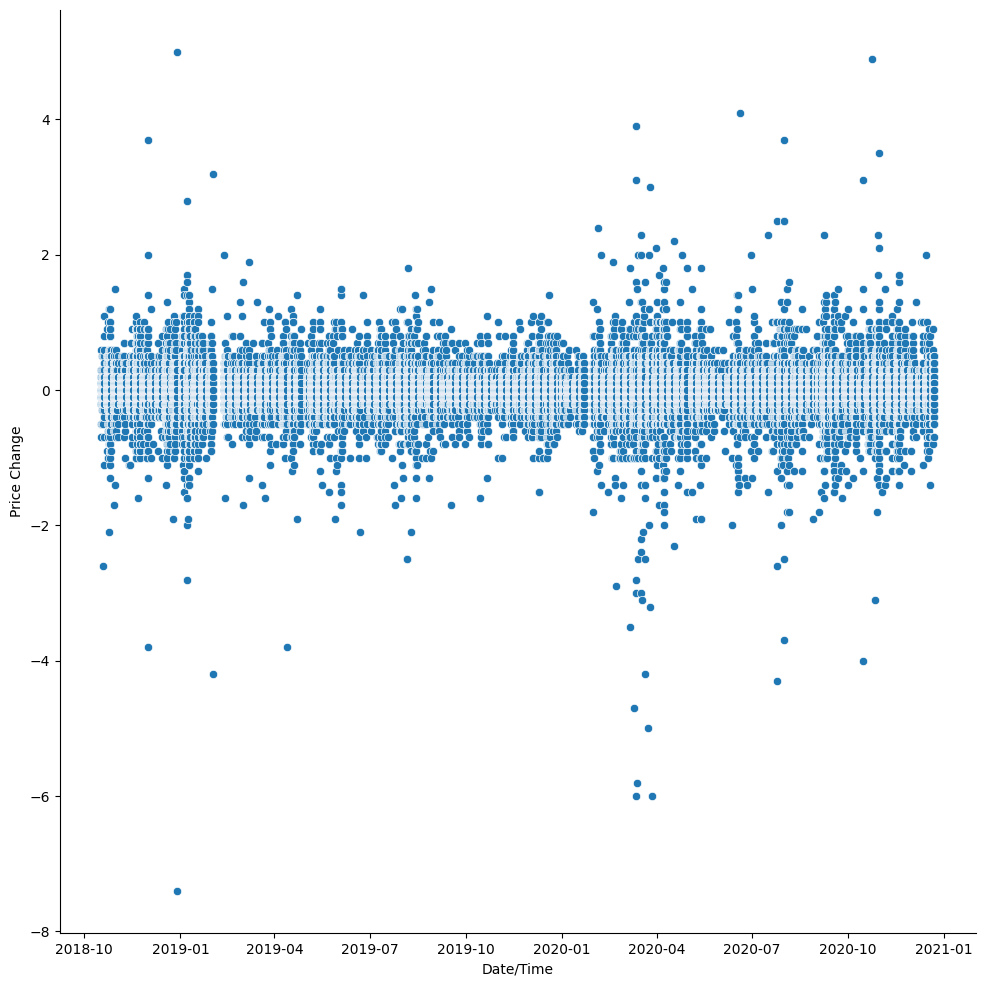

In [401]:
# Assuming you have a DataFrame named 'df'
selected_columns = df[['Price Change', 'Date/Time']]
sns.pairplot(selected_columns, x_vars='Date/Time', y_vars=['Price Change'], size=10, kind='scatter')

In [402]:
# Xử lý các giá trị ngoại lệ
df = df[(np.abs(zscore(df[['Close', 'Price Change']])) < 3).all(axis=1)]

In [378]:
# selected_columns_new = df[['Open', 'High', 'Low', 'Close', 'Price Change']]

In [379]:
# numeric_df = selected_columns_new.select_dtypes(include=[float, int])
# correlation_matrix = numeric_df.corr()
# print(correlation_matrix)


                  Open      High       Low     Close  Price Change
Open          1.000000  0.999946  0.999949  0.999917     -0.005485
High          0.999946  1.000000  0.999901  0.999952     -0.006418
Low           0.999949  0.999901  1.000000  0.999941     -0.006588
Close         0.999917  0.999952  0.999941  1.000000     -0.008734
Price Change -0.005485 -0.006418 -0.006588 -0.008734      1.000000


Correlation matrix for FPT:
                       Open     Close      High       Low    Volume  \
Open               1.000000  0.999970  0.999982  0.999980  0.077920   
Close              0.999970  1.000000  0.999982  0.999980  0.077944   
High               0.999982  0.999982  1.000000  0.999968  0.078940   
Low                0.999980  0.999980  0.999968  1.000000  0.076826   
Volume             0.077920  0.077944  0.078940  0.076826  1.000000   
Log Close          0.996884  0.996911  0.996911  0.996870  0.078566   
Percentage Change -0.000557  0.003417  0.001001  0.001005 -0.031515   
Moving Average 5   0.999960  0.999953  0.999957  0.999955  0.078119   
Moving Average 10  0.999907  0.999892  0.999901  0.999899  0.078076   
Std Dev 5          0.137687  0.137805  0.139319  0.136167  0.267713   
Std Dev 10         0.123987  0.124077  0.125431  0.122537  0.244117   
Year               0.516948  0.516909  0.517198  0.516606  0.060620   
Month              0.654067  0.654118  0.653922  

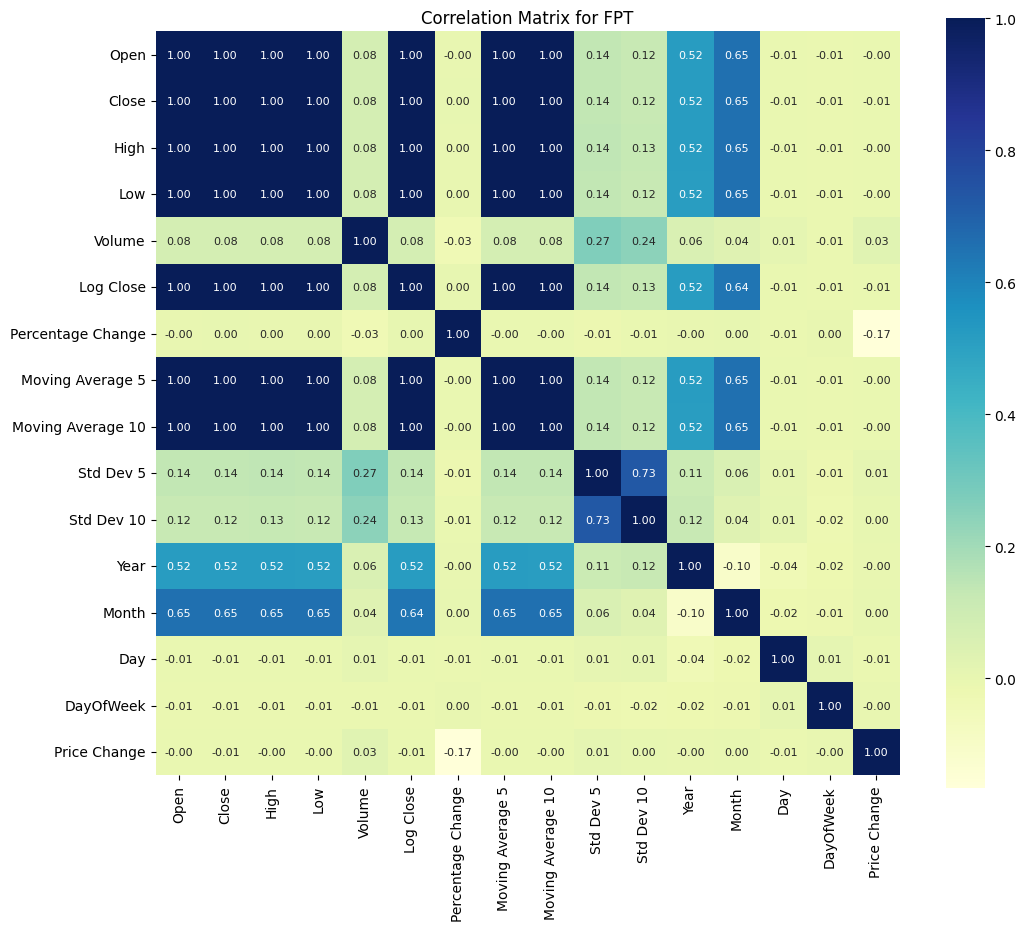

Correlation matrix for MSN:
                       Open     Close      High       Low    Volume  \
Open               1.000000  0.999940  0.999946  0.999962 -0.039262   
Close              0.999940  1.000000  0.999948  0.999960 -0.039188   
High               0.999946  0.999948  1.000000  0.999910 -0.038576   
Low                0.999962  0.999960  0.999910  1.000000 -0.039693   
Volume            -0.039262 -0.039188 -0.038576 -0.039693  1.000000   
Log Close          0.995236  0.995287  0.995236  0.995276 -0.040573   
Percentage Change  0.002092  0.007200  0.004237  0.003576  0.042953   
Moving Average 5   0.999932  0.999932  0.999914  0.999934 -0.039635   
Moving Average 10  0.999878  0.999870  0.999857  0.999878 -0.039764   
Std Dev 5          0.211336  0.211937  0.214891  0.209002  0.129179   
Std Dev 10         0.237706  0.237995  0.240852  0.235494  0.093074   
Year              -0.726431 -0.726471 -0.725117 -0.727064  0.052246   
Month              0.012666  0.012666  0.013505  

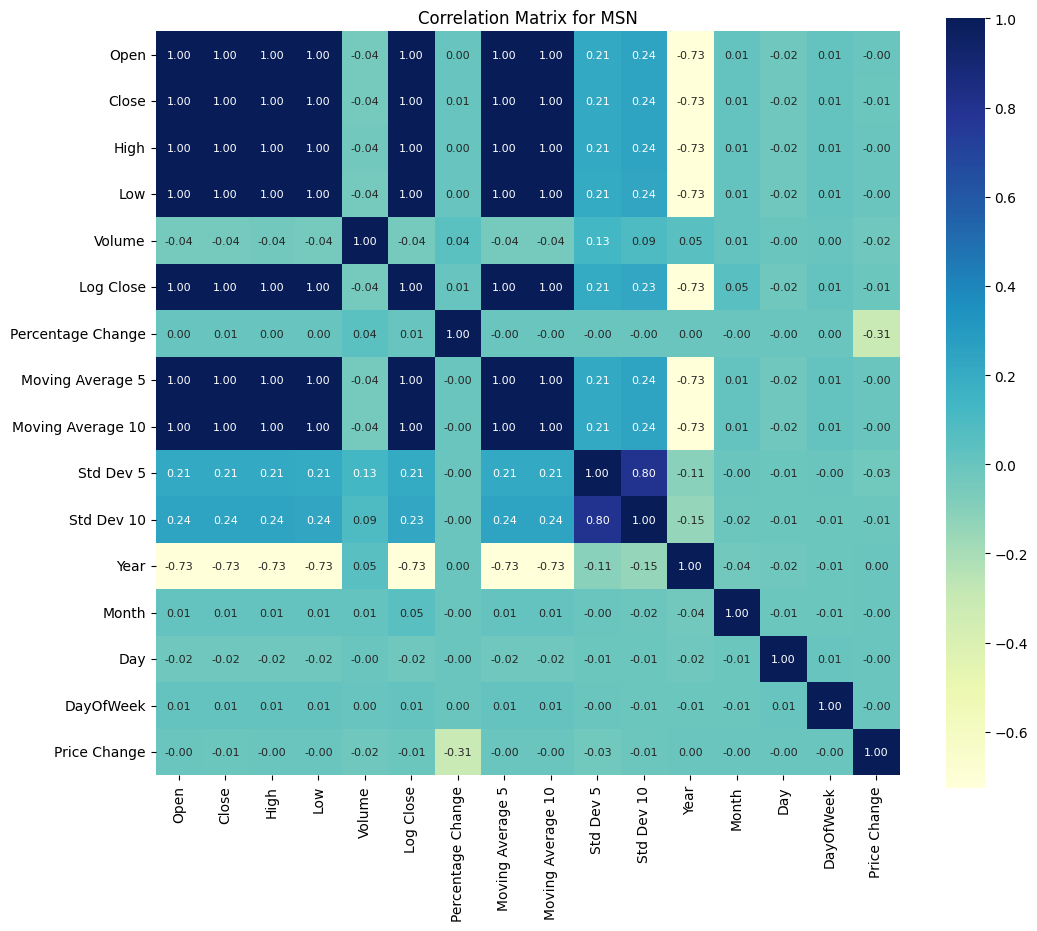

Correlation matrix for PNJ:
                       Open     Close      High       Low    Volume  \
Open               1.000000  0.998392  0.998752  0.999072 -0.050688   
Close              0.998392  1.000000  0.998738  0.999091 -0.050665   
High               0.998752  0.998738  1.000000  0.998090 -0.046370   
Low                0.999072  0.999091  0.998090  1.000000 -0.053304   
Volume            -0.050688 -0.050665 -0.046370 -0.053304  1.000000   
Log Close          0.995292  0.996746  0.995541  0.996020 -0.049778   
Percentage Change  0.013812  0.036754  0.024733  0.017293 -0.008093   
Moving Average 5   0.998644  0.998963  0.998380  0.999148 -0.050446   
Moving Average 10  0.998565  0.998709  0.998207  0.999043 -0.050523   
Std Dev 5          0.379030  0.384956  0.392951  0.371575  0.007105   
Std Dev 10         0.439192  0.442177  0.452587  0.430762 -0.000769   
Year              -0.408343 -0.408556 -0.411401 -0.406855  0.117858   
Month             -0.016302 -0.016153 -0.018496 -

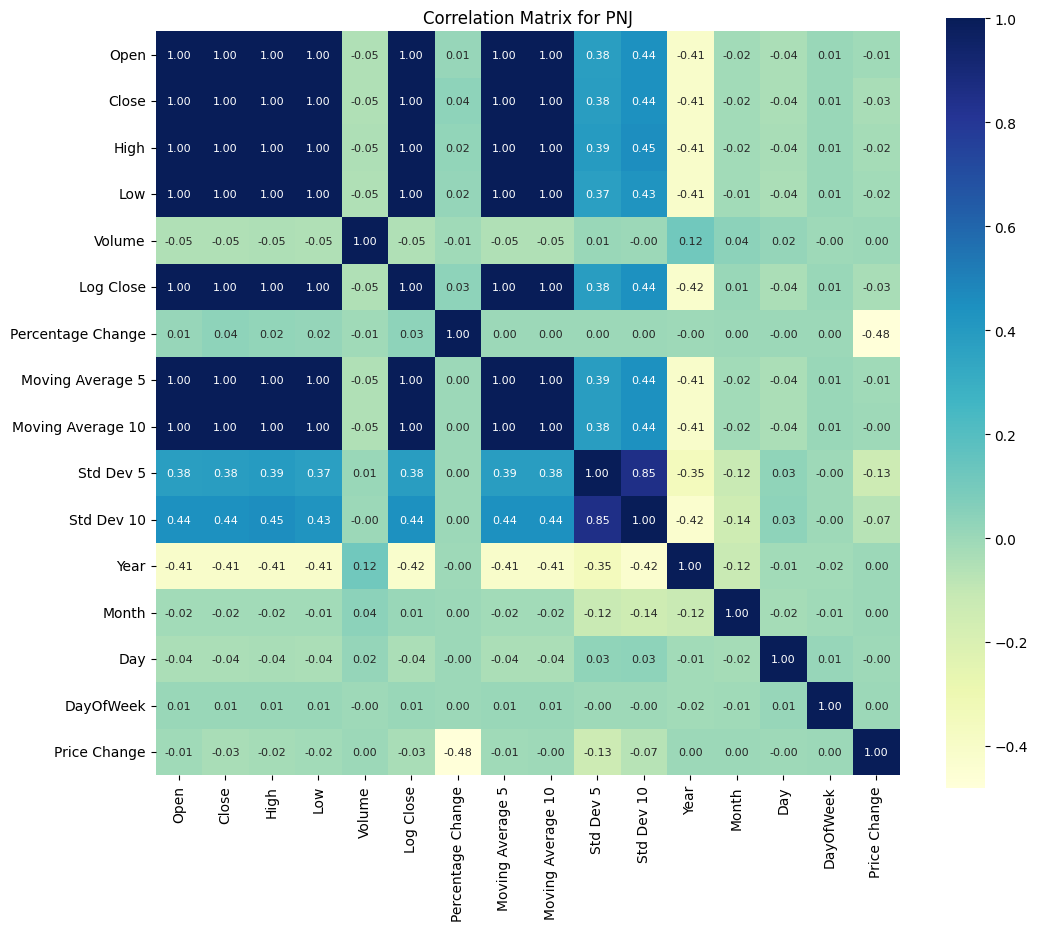

Correlation matrix for VIC:
                       Open     Close      High       Low    Volume  \
Open               1.000000  0.999917  0.999946  0.999949 -0.016135   
Close              0.999917  1.000000  0.999952  0.999941 -0.016064   
High               0.999946  0.999952  1.000000  0.999901 -0.015678   
Low                0.999949  0.999941  0.999901  1.000000 -0.016563   
Volume            -0.016135 -0.016064 -0.015678 -0.016563  1.000000   
Log Close          0.998392  0.998479  0.998430  0.998412 -0.015550   
Percentage Change  0.002307  0.007879  0.004378  0.004480 -0.006951   
Moving Average 5   0.999885  0.999883  0.999888  0.999874 -0.016190   
Moving Average 10  0.999779  0.999763  0.999777  0.999764 -0.016433   
Std Dev 5         -0.095066 -0.094950 -0.092310 -0.097832  0.145848   
Std Dev 10        -0.111703 -0.111528 -0.109323 -0.114051  0.103408   
Year              -0.436769 -0.437092 -0.436845 -0.436925  0.000121   
Month              0.018309  0.018283  0.017989  

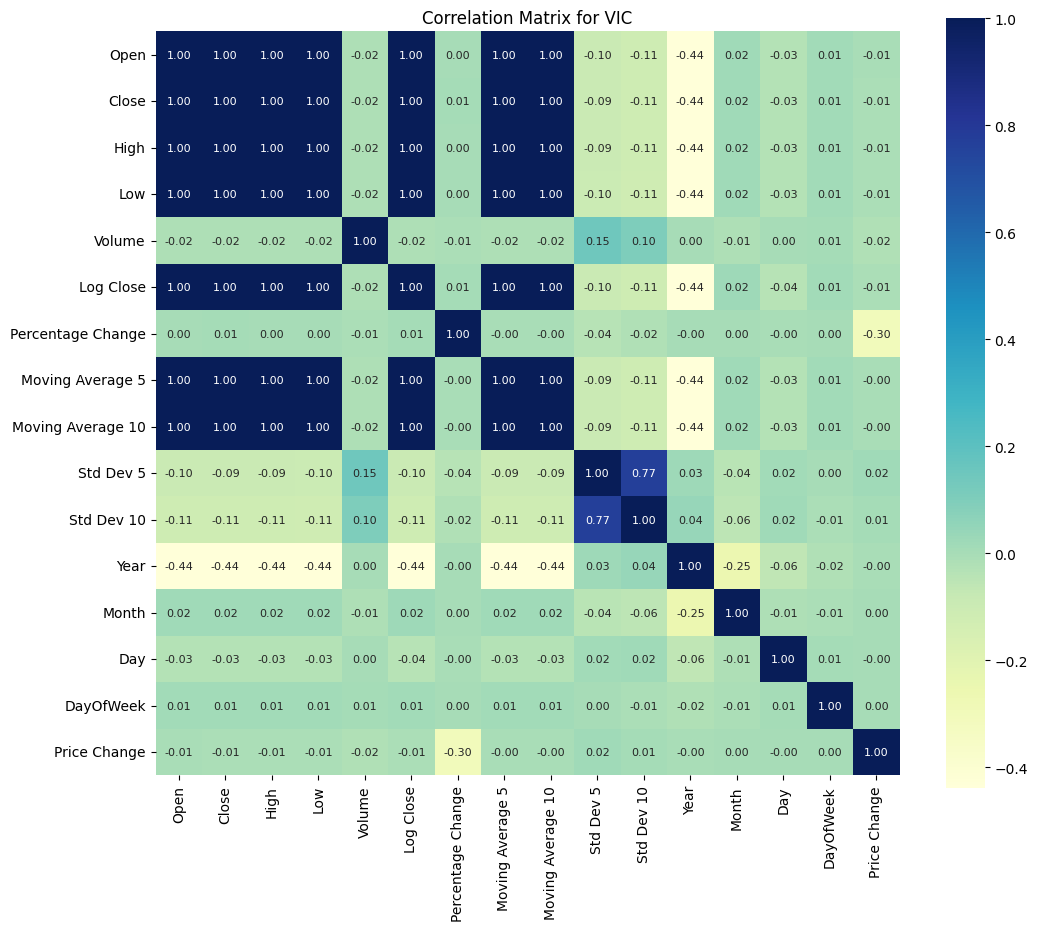

In [403]:
for name, df in processed_data.items():
    # Chuyển đổi cột 'Date/Time' thành các giá trị số
    df['Year'] = df['Date/Time'].dt.year
    df['Month'] = df['Date/Time'].dt.month
    df['Day'] = df['Date/Time'].dt.day
    df['DayOfWeek'] = df['Date/Time'].dt.dayofweek
    
    # Chọn các cột để tính toán độ tương quan
    columns_to_correlate = [
        'Open', 'Close', 'High', 'Low', 'Volume', 
        'Log Close', 'Percentage Change', 'Moving Average 5', 
        'Moving Average 10', 'Std Dev 5', 'Std Dev 10', 
        'Year', 'Month', 'Day', 'DayOfWeek', 'Price Change'
    ]
    correlation_matrix = df[columns_to_correlate].corr()
    
    print(f"Correlation matrix for {name}:")
    print(correlation_matrix)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', annot_kws={'size': 8}, cbar=True, square=True, fmt='.2f')
    plt.title(f'Correlation Matrix for {name}')
    plt.show()

In [381]:
max_day = df['Date/Time'].max()
min_day = df['Date/Time'].min()

number_day = (max_day-min_day).days

print (number_day)

797


In [382]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Tham số
# time_step = number_day  # Số ngày để dự đoán
time_step = 60

# Tạo tập huấn luyện và kiểm tra cho từng mã cổ phiếu
train_test_split = 0.8
datasets = {}
for ticker, (data, scaler) in processed_data.items():
    train_size = int(len(data) * train_test_split)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    # Thay đổi shape để phù hợp với LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    datasets[ticker] = (X_train, y_train, X_test, y_test, scaler)


In [383]:
# Kích thước tập dữ liệu của từng mã cổ phiếu

for ticker, (X_train, y_train, X_test, y_test, scaler) in datasets.items():
    print(f"{ticker} - Train Data Shape: {X_train.shape}, Test Data Shape: {X_test.shape}")


FPT - Train Data Shape: (77863, 60, 1), Test Data Shape: (19421, 60, 1)
MSN - Train Data Shape: (108222, 60, 1), Test Data Shape: (27010, 60, 1)
PNJ - Train Data Shape: (100186, 60, 1), Test Data Shape: (25001, 60, 1)
VIC - Train Data Shape: (80951, 60, 1), Test Data Shape: (20193, 60, 1)


In [384]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(LSTM(64, return_sequences=False))  # Giảm số đơn vị trong lớp cuối cùng
    model.add(Dense(32, activation='relu'))  # Thêm một lớp Dense
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Huấn luyện mô hình cho từng mã cổ phiếu
models = {}
for ticker, (X_train, y_train, X_test, y_test, scaler) in datasets.items():
    model = build_lstm_model((X_train.shape[1], 1))
    model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1)
    models[ticker] = model


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - loss: 0.0117
Epoch 2/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - loss: 2.8014e-04
Epoch 3/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 64s 104ms/step - loss: 2.8836e-04
Epoch 4/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - loss: 2.8886e-04
Epoch 5/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - loss: 2.9055e-04
Epoch 6/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 65s 106ms/step - loss: 2.9243e-04
Epoch 7/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 66s 108ms/step - loss: 2.8115e-04
Epoch 8/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 63s 104ms/step - loss: 2.9538e-04
Epoch 9/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - loss: 3.1230e-04
Epoch 10/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - loss: 2.8177e-04
Epoch 11/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - loss: 2.9902e-04
Epoch 12/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 64s 105ms/step - loss: 2.8300e-04
Epoch 13/100
609/609 ━━━━━━━━━━━━━━━━━━━━ 63s 103ms/step - loss: 2.9667e-04
Epoch 14/100
609/609 ━━━━

In [385]:
print (X_train.shape) #(77893, 30, 1)
print (y_train.shape) #(77893,)
print (X_test.shape) #(19451, 30, 1)
print (y_test.shape) #(19451, 1)

(80951, 60, 1)
(80951,)
(20193, 60, 1)
(20193,)


In [386]:
from datetime import datetime

max_day = df['Date/Time'].max()
min_day = df['Date/Time'].min()

number_day = max_day - min_day

print (number_day.days)

797


607/607 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
RMSE for FPT: 0.0689897055760453


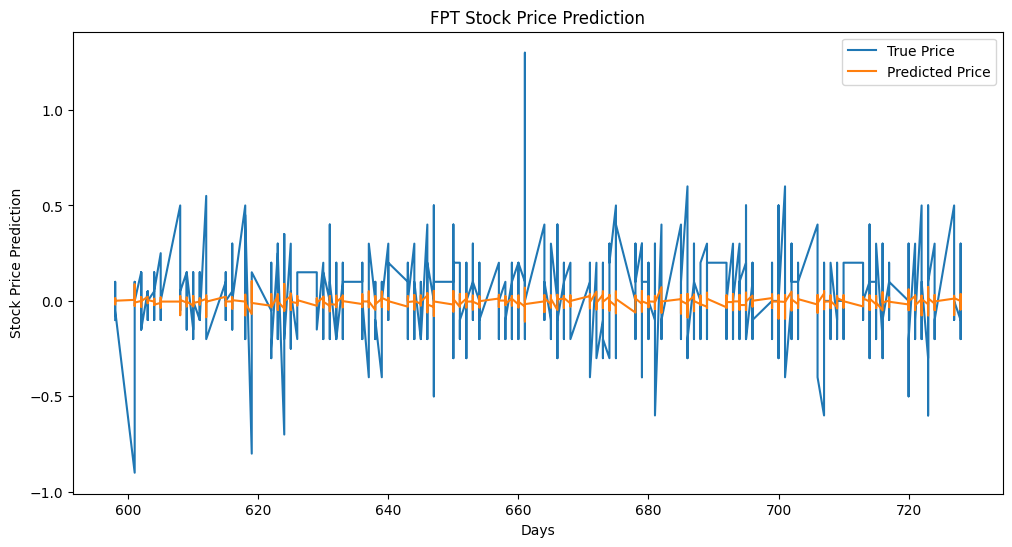

845/845 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step
RMSE for MSN: 0.2592561947239496


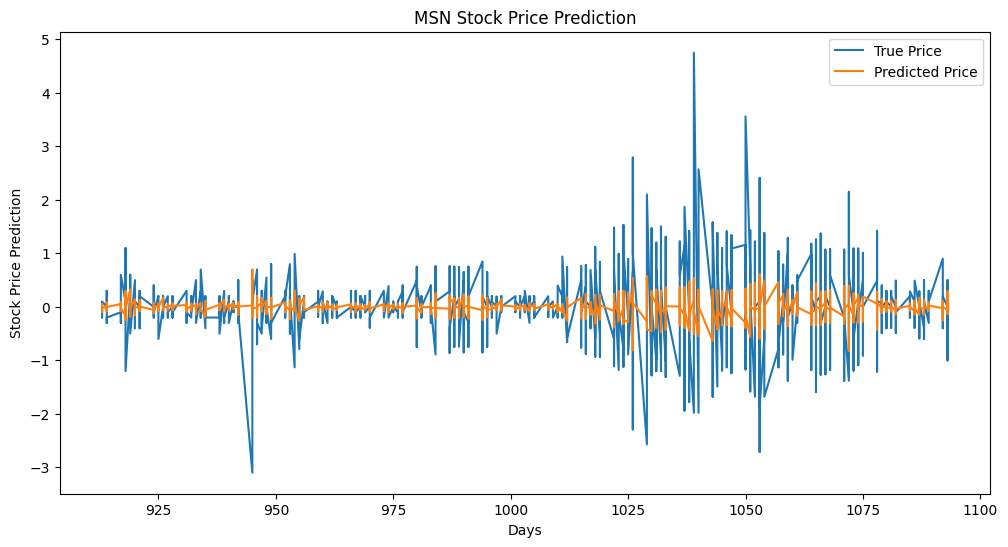

782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step
RMSE for PNJ: 0.15998108409007622


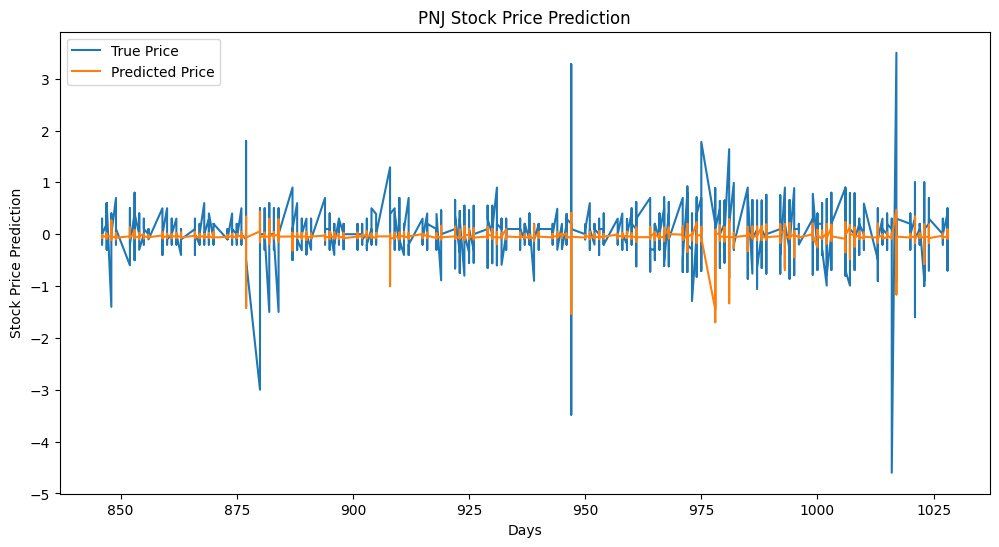

632/632 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step
RMSE for VIC: 0.19615517326108983


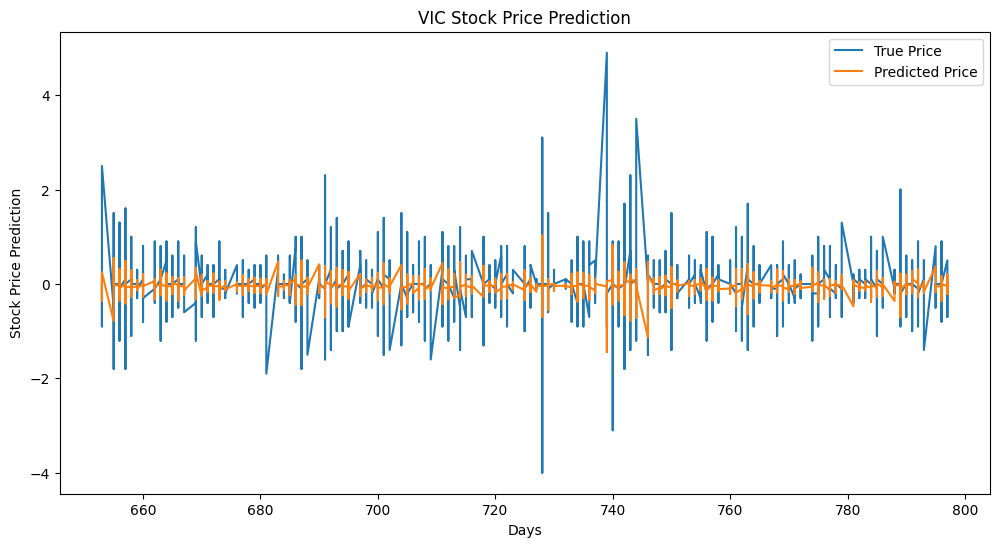

In [387]:
for ticker, (X_train, y_train, X_test, y_test, scaler) in datasets.items():
    model = models[ticker]
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Tính RMSE
    rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
    print(f"RMSE for {ticker}: {rmse}")

    df = dataframes[ticker]  # Lấy toàn bộ DataFrame
    start_date = df['Date/Time'].min()  # Ngày đầu tiên trong toàn bộ dữ liệu
    date_range = (df['Date/Time'] - start_date).dt.days  # Số ngày kể từ ngày đầu tiên

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(date_range.iloc[-len(y_test):], y_test, label='True Price')
    plt.plot(date_range.iloc[-len(y_test):], predictions, label='Predicted Price')
    plt.title(f"{ticker} Stock Price Prediction")
    plt.xlabel('Days')
    plt.ylabel('Stock Price Prediction')
    plt.legend()
    plt.show()



In [388]:
# Tính số ngày cho từng mã cổ phiếu
for ticker in dataframes.keys():
    df = dataframes[ticker]
    start_date = df['Date/Time'].min()
    end_date = df['Date/Time'].max()

    # Tính số ngày giữa ngày bắt đầu và ngày kết thúc
    number_of_days = (end_date - start_date).days
    print(f"Số ngày của mã {ticker}: {number_of_days}")


Số ngày của mã FPT: 728
Số ngày của mã MSN: 1093
Số ngày của mã PNJ: 1028
Số ngày của mã VIC: 797
